# Проект Яндекс.Музыка

## Обнаружение каверов музыкальных треков

Для разнообразия плейлиста пользователя некоторый интерес представляет добавление в список проигрывания разнообразных исполнений песен, т.н. называемых каверов. Их отличительной особенностью является значительное совпадение текстов песни, но наложенных на видоизмененную музыку.

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей. Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков.
Для поиска оригинала песни или поиска каверов на песню требуется предоставить решение. 

### Исходные данные

Исходными данными выступают некоторые метаданные песни и разметка кавер/не кавер. При этом ограничений на включение дополнительной информации не накладывается. Необходимо разработать ML-продукт, который:

- Находит все кавер-треки и/или исходники к заданному треку в датасете
- Перечисляет все кавер-треки и/или оригиналы к заданному, указывает положение данного трека в цепочке каверов

### Требования и замечания
Априорно мы утверждаем, что оригинальная песня - это песня, появившаяся раньше всех из найденных. Поэтому к любому решению стоит добавлять определенную вероятность того, что песня не оригинальная, т.к. оригинал не вошел в какую-либо базу музыки. 

## Обзор исходных данных (EDA) 

Нам были представлена база данных о треках, состаящая из трех датасетов:

- `covers.json` содержит разметку каверов, сделанную редакторами сервиса;

- `meta.json` содержит метаинформацию о треках;

- `lyrics.json` содержит тексты песен.

Для начала переведем json формат в датафрейм:

In [6]:
import pandas as pd
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
import musicbrainzngs as m
import requests
import re
import pydash
import time

from secondhandsongs import Api
from collections import OrderedDict
from IPython.display import clear_output


In [7]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [8]:
def read_json(file_name:str):
    data = []

    # Открываем файл JSON для чтения
    with open(file_name, 'r') as file:
        for line in file:
            # Пытаемся разобрать каждую строку JSON и добавить ее в список
            try:
                obj = json.loads(line)
                data.append(obj)
            except json.JSONDecodeError:
                print(f"Ошибка при разборе строки: {line}")
    return pd.DataFrame(data)

covers = read_json('covers.json')
text = read_json('lyrics.json')
meta = read_json('meta.json')

## Файл сovers:

In [9]:
covers

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER
...,...,...,...
71592,4788e0bf61d80ef5ec9380aa8a8119d9,4788e0bf61d80ef5ec9380aa8a8119d9,ORIGINAL
71593,None,78b2db35476f134dc3cdfbf4d77ba034,COVER
71594,None,e720ff378efe032df56e0e656a6a92d3,COVER
71595,554e33d79e258da91149c3a4985cf6a1,554e33d79e258da91149c3a4985cf6a1,ORIGINAL


In [10]:
covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


Датафрейм `covers` содержит следующие данные:

- `track_id` - уникальный идентификатор трека;

- `track_remake_type` - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;

- `original_track_id` - уникальный идентификатор исходного трека.

Как видно из данных, столбец `original_track_id` имеет пропуски в данных.

Посмотрим, содержит ли датафрейм дубликаты:

In [11]:
covers.duplicated().sum()

0

Дубликатов нет, посмотрим, имеются ли одинаковые треки по столбцу `track_id`:

In [12]:
covers['track_id'].nunique()

71597

Все треки уникальные. Построим гистограмму распределения типов треков на кавер и оригинал:

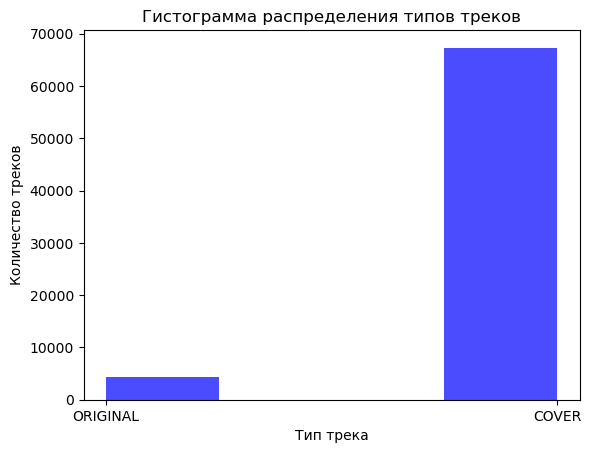

track_remake_type
COVER       67304
ORIGINAL     4293
Name: count, dtype: int64


In [13]:
plt.hist(covers['track_remake_type'], bins=4, color='blue', alpha=0.7)
plt.xlabel('Тип трека')
plt.ylabel('Количество треков')
plt.title('Гистограмма распределения типов треков')
plt.show()
print(covers['track_remake_type'].value_counts())

Как видим каверов датафрейм содежрит намного больше:

- количество каверов - 67304;
- количество оригиналов - 4293.

### Краткий вывод

Датафрейм `covers` содержит уникальные значения `track_id` и `track_remake_type`, однако имеет пропуски в столбце `original_track_id`.

## Text

Датафрейм `text` содержит следующие данные:

- `track_id` - уникальный идентификатор трека;

- `lyricId` - уникальный идентификатор текста;

- `text` - текст трека.

In [14]:
text

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659
...,...,...,...
11409,90522f12df92da5d585f8f6ec9bb34b5,All my little plans and schemes\nLost like som...,b734225e54122798535b40666e6e361e
11410,b82bd468c888ae17d2e976c8cf3b9d4c,I will make my way\nI'm trying to survive anot...,b3cbb82e4ef67e75b1e47054a681db86
11411,22bae9d3185254ea34072c692a2cd63d,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d
11412,0979b4049635e1c0fc161573f75ab23a,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d


In [15]:
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


Датафрейм `text` содежрит 11414 строк, не имеет пропусков и все значения типа object. Проверим, имеются ли дубликаты:

In [16]:
text.duplicated().sum()

0

### Краткий вывод

Датафрем `text` не содержит дубликатов и имеет 11414 уникальных значений.

## Meta

Датафрейм `meta` содержит следующие данные:

- `track_id` - уникальный идентификатор трека;

- `dttm` - первая дата появления информации о треке;

- `title` - название трека;

- `language` - язык исполнения;

- `isrc` - международный уникальный идентификатор трека;

- `genres` - жанры;

- `duration` - длительность трека;

In [17]:
meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,[INDIE],212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,[POP],237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,[ALTERNATIVE],215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,[ALTERNATIVE],251010.0


In [18]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


Датафрейм содержит 71768 строк, сразу видно, что столбцы `language` и `isrc` имеют пропуски, также столбец даты `dttm` имеет нечитабельный формат данных типа UNIXTIME. 

In [19]:
meta.isnull().sum()

track_id        1
dttm            1
title           1
language    49800
isrc          314
genres          1
duration        1
dtype: int64

In [20]:
meta.dropna(inplace=True,axis=0)
meta['dttm'] = meta['dttm'].div(1000).apply(lambda x: datetime.fromtimestamp(x))

Функция убирает все пропуски, в том числе и в столбцах `language` и `isrc`.

In [21]:
meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-17 01:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 18:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
18,55a4890cc667212a048ce81b4049d1ea,2021-11-24 20:59:05,Tacones Rojos,ES,GBKPL2174553,"[POP, FOLK, LATINFOLK]",181230.0
25,94093810e71074bec5a6990c1c214165,2022-10-20 01:00:00,Humsafar,HI,GX3HH2123738,[FOLK],153690.0
26,2b74d8dc05d365e51cf4ff2bcc9727f0,2021-12-10 01:00:00,Die Together,EN,QZS672179786,[DANCE],177190.0
...,...,...,...,...,...,...,...
71762,495babc700c0c6b5b8549d49f163d3cb,2021-07-04 01:00:00,Stay With Me,EN,GBKPL1955058,"[JAZZ, VOCALJAZZ]",152090.0
71764,4be93dea1715e54db86aaa7f7e9bfb10,2019-06-13 09:20:09,Chanceuse,FR,CAISO1800023,[INDIE],212690.0
71766,26b6aca1c6a02ad0e2a939164716657e,2019-06-13 21:50:02,Vacation,EN,USA2B1511447,[ALTERNATIVE],215210.0
71767,d904dda141238e6ad1b428bfbb21262d,2019-06-13 21:50:02,Dance Hall Days,EN,USA2B1511448,[ALTERNATIVE],251010.0


In [22]:
print(meta['dttm'].min())
print(meta['dttm'].max())

2009-08-10 21:32:06
2023-10-18 01:00:00


Дату исправили. Посмотрим на распределение данных:

In [23]:
meta['track_id'].nunique()

21964

Все значения `track_id` уникальны, что с названиями треков:

In [24]:
meta['title'].value_counts()

title
Smooth Criminal            53
Wicked Game                45
Smells Like Teen Spirit    35
Toxic                      32
Baby One More Time         28
                           ..
Quick Death in Texas        1
Brain Stew                  1
Carolina Drama              1
Everything We Need          1
17                          1
Name: count, Length: 16288, dtype: int64

В названиях имеются повторы, но если `track_id` уникальны, то вероятно тут сидят и каверы.

In [25]:
meta['language'].value_counts().head(10)

language
EN    15322
ES     1747
RU     1553
IT      907
HI      285
DE      238
ZH      212
FR      210
JA      174
VI      162
Name: count, dtype: int64

In [26]:
meta.loc[(meta['language'] != 'EN') & (meta['language'] != 'RU') &
         (meta['language'] != 'ES') & (meta['language'] != 'IT') , 'language'] = 'Other'

Text(0.5, 1.0, 'Гистограмма распределения треков по языкам')

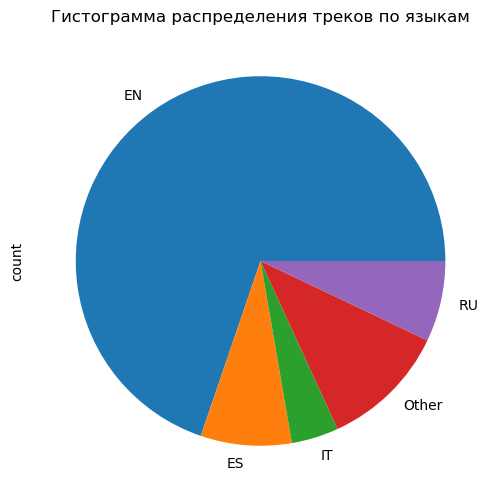

In [27]:
meta.groupby(['language'])['language'].value_counts().plot(kind='pie', subplots=True,figsize = (6,6))
plt.title('Гистограмма распределения треков по языкам')

Как видим, большую часть данных составляют англоязычные треки, далее идут испаноязычные и русскоязычные.

In [28]:
meta['genres'].value_counts()

genres
[POP]                                               5742
[ROCK, ALLROCK]                                     2049
[DANCE]                                             1357
[FOLK, LATINFOLK]                                   1081
[ELECTRONICS]                                       1070
                                                    ... 
[SPIRITUAL, NEWAGE, ELECTRONICS]                       1
[CLASSICAL, NEWAGE, ELECTRONICS, CLASSICALMUSIC]       1
[REGGAE, SKA]                                          1
[ROCK, ELECTRONICS, ALLROCK]                           1
[ROCK, ALLROCK, FOLKGENRE]                             1
Name: count, Length: 210, dtype: int64

Самым популярным жанром оказался `POP`, далее идет `ROCK` и `DANCE`. Причем имеются многожанровые треки, поэтому и разброс уникальных значений столь велик.

In [29]:
meta['isrc'].nunique()

21933

Повторы имеются и в столбце `isrc`

In [30]:
meta['isrc'].value_counts()

isrc
QZGWX2002100    2
GBAFQ0700594    2
QZNC62100542    2
QZGWW2040131    2
USAT29901394    2
               ..
QZGWX2217144    1
QZGWX2217143    1
QZGWX2217142    1
QZGWX2217141    1
FR59R1921791    1
Name: count, Length: 21933, dtype: int64

Наглядно видны повторы. Если `isrc` - международный уникальный идентификатор трека, а `track_id` - уникальный идентификатор трека. Если у нас все значения `track_id` уникальны, но имеются повторы `isrc`, то значит в системе имеется опасное дублирование информации. 

Столбец `duration` показывает длительноть треков:

In [31]:
print(f"Медианная длительность трека составляет", meta['duration'].median())

Медианная длительность трека составляет 202320.0


In [32]:
print(f"Средняя длительность трека составляет", meta['duration'].mean())

Средняя длительность трека составляет 204612.5840921508


## Разработка решения для поиска каверов. 

Рассмотрим способы нахождения каверов. Сразу заметим, что в исходной информации, даже обладая разными базами не всегда удается установить оригинальный трек. Более того, лишь ISRC позволяет произвести более менее однозначное соответствие трека, т.к.:
 - имена песни могут быть одинаковыми
 - дата добавления трека в базу Яндекса не является уникальной
 - длительность трека,язык и жанр являются косвенным методом определения трека
 - текст песни приведен лишь для малой части песен. 
 
 Треки, где отсутствует ISRC, для задачи поиска каверов не подходят, т.к. по исходной информации они могут быть как кавером так и оригиналом. 

### Путь первый - через сравнение текстов.

Показатель сходства текстов является важным признаком сходства песен. При очень высокой степени сходства можно утверждать, что  перед нами связанные песни. С некоторой вероятностью самая первая песня является оригиналом. Большой проблемой является то, что не для каждой песни имеются слова, даже если использовать внешние источники информации. С развитием технологий появятся нейросети, которые смогут составлять автоматически тексты к песне, что даст большое приемущество этому методу. На данный момент этот вариант сложно реализуем и не покрывает песни без слов. 

Вторая проблема - проклятие размерности. Имея несколько миллионов треков с закодированными через эмбендинги текстами получаются огромные разреженные матрицы. Для классификации требуется вычисление расстояний(косинусного, левенштейна или другого) между песнями.  Такой процесс возможно производить в фоне, создавая списки каверов к родительскому оригиналу, однако требует предварительного скачивания большой базы текстов, применения токенизаторов для разных языков.

Несколько упрощенной моделью будет создание из текста каждой песни списка 10...15 самых повторяющихся слов длиной не менее 4 символов. Связанные песни можно определять или прямым сравнением или расстоянием Левенштейна. Это позволит иметь быструю и легковесную модель, инвариантную к языкам. Ввиду слабой базы текстов нам этот вариант не подходит.

### Путь второй - через языковые модели. 
В последнее время языковые модели могут отвечать на вопросы в требуемом формате, что возможно использовать для ответа на вопрос об оригинальном исполнителе песни. К сожалению проведенное тестирование на примере chatGPT показало, что модель выдает уверенно неправильные ответы. Однако вероятность правильного ответа не равна нулю. Модель вполне можно использовать для выяснения песни-оригинала для кавера. Пример простого запроса:

*Кто написал песню нас не догонят в формате "исполнитель:песня:год"*

ответ:

*Исполнитель: t.A.T.u.*
*Песня: Нас не догонят*
*Год выпуска: 2001*

С помощью регулярного выражения можно выбрать нужную информацию без труда. 

### Путь третий - через запросы к информационным сайтам.
Имеется несколько баз, предоставляющих информацию о выпущенных песнях. Зачастую каверы имеют одинаковое название с оригиналом. Получив список песен можно найти оригинал как первую песню из найденного. Это хороший метод, если название песни не менялось и база более менее полная. Среди проблем можно назвать трудоемкость и неоднородность информации. Необходимо бороться с исключением похожих названий. 

### Путь четвертый - через специализированные сайты. 
Ряд сайтов предоставляют сервис, где перечислены оригинальные песни и их каверы. Плюсом такого решения является высокая точность предсказания, т.к. база корректируется и обновляется сообществом. Например [secondhandsongs](http://secondhandsongs.com) обеспечивает такой функционал и предоставляет API. 

Каждый из этих методов имеет плюсы и минусы. Вполне возможно использовать все эти методы вместе, получив ансамбль предсказаний, где с некоторым весом брать предсказания каждого метода. При этом производительность конечно пострадает, однако это допустимо для работы в фоне.  

# Первая модель. 
Реализация модели четвертым путем показалась наиболее рациональным, т.к. этот метод обеспечивает неплохую точность, умеренную скорость и среднюю сложность реализации. 

В качестве источника выбор пал на сайт [secondhandsongs](http://secondhandsongs.com). Сервис представляет собой базу сообщества, которое собирает информацию про каверы и их оригиналы. Большим плюсом является формат, в котором выдается результат: cоставляется список каверов, выдается id оригинальной песни. Недостатком сервиса является то, что он не поддерживает поиск по ISRC, поэтому однозначно установить правильность найденного результата нельзя. Вместе с тем такую оговорку следуюет добавлять почти ко всем вариантам, т.к.ISCR появился только в середине 80-х, а многие песни происходят из более далеких времен. Название исполнителя и альтернативные названия песни получаем через БД Deezer и БД MusicBrainz. Для работы используется API, который работает следующим образом: посылается ссылка-запрос, а сайт(если запрос верный) в ответ присылает json-файл.

Результаты запроса аккумулируются в два списка - список названий песен и список названий исполнителя. Это необходимо для того, чтобы найти разные названия одной и той же песни и исполнителя.

In [33]:
def find_info_by_isrc(isrc, track = None):
    """
    Функция делает запрос на сайт musicbrainz и deezer для поиска
    названия исполнителя и названия песни по ISCR. Т.к. песня может 
    по-разному называться в разных базах. Функция возвращает список 
    как может называться исполнитель и песня.
    """
    # создаем списки для сбора вариаций названий песни и исполнителя
    artist = []
    track_similar = [track]
    print('Делаем запрос в Deezer и MusicBrainz на поиск песни и названия исполнителя')
    # делаем запрос на Deezer и получаем словарь результатов
    dzr_res = requests.get('https://api.deezer.com/2.0/track/isrc:'+isrc).json()
    if 'error' not in dzr_res:
        artist.append( dzr_res.get("artist").get("name") )
        track_similar.append( dzr_res.get("title_short") )
    
    # делаем запрос на Musicbrainz и получаем json
    m.set_useragent("custom_app", "0.01", "sidordima@gmail.com")
    
    try:
        mb_res = m.get_recordings_by_isrc(isrc = isrc)
    except:
        mb_res = None

    # если ответ ненулевой, то выцепляем данные
    # в глубоких словарях поможет библиотека pydash
    if mb_res!=None:
        mb_artist = pydash.get(mb_res, "isrc.recording-list.0.artist-credit.0.artist.name")
        mb_track = pydash.get(mb_res, "isrc.recording-list.0.title")
        artist.append(mb_artist)
        track_similar.append(mb_track)

    # очищаем списки от повторов и None
    artist = list(filter(None, artist))
    artist = list(OrderedDict.fromkeys(artist)) 
    track_similar = list(filter(None, track_similar))
    track_similar = list(OrderedDict.fromkeys(track_similar)) 
    # возвращаем варианты названия песни и артиста 
    return artist,track_similar

После получения названий песни и артиста ищем эту песню на secondhandsong(далее SHS). Такой поиск - задача нетривиальная. Сначала ищется песня по названию, если песня одна - скорее всего это искомая песня. Если песен много, то ищется дополнительно совпадающее название исполнителя. Если ничего не нашлось, то песня ищется по другому названию. И так до перебора всех вариантов. Ввиду ограничения в 10-20 запросов в минуту для бесплатного получения информации поиск не самый быстрый.  

In [34]:
def secondhand_find_song(list_track = None,list_artist = None):
    """
    Запрашиваем результат с сайта secondhand. Для этого ищем id песни запросами 
    из разных названий одной и тоже песни или автора. Возвращаем id с SHS
    """
    # добавим вариант поиска без автора с помощью вставки None в список исполнителей
    list_artist.insert(0,None)
    # активируем режим поиска и обнуляем переменные
    search = True
    i, k = 0, 0
    while search:
        """
        Делаем запрос для получения id. 
        Если one_result=True-значит нашлась только одна песня, это идеальный вариант,
        можно выходить из поиска. Если one_result=False-значит нашлось много песен, 
        требуется уточнение исполнителя. Если is_shs равно None, то пытаемся другое
        название этой же песни найти. 
        """
        print('Идет поиск трека:', list_track[i],", исполнитель: ",list_artist[k])
        id_shs, one_result = SHS_get_id(song=list_track[i], artist=list_artist[k])
        print("Получили такой ids", id_shs, 'and' ,'вариант один',one_result)
        if id_shs != None and one_result==True:
            search = False
            
        elif id_shs != None and one_result==False:
            # если много результатов, то меняем название исполнителя с None 
            k += 1
            # если много одинаковых песен с разными исполнителями
            if k>(len(list_artist)-1):
                return id_shs
        elif id_shs == None:
            # если не нашли песню, то ищем по другому названию
            if i<(len(list_track)-1):
                i += 1
                k = 0
            else:
                return None
        else:
            search = False
            return id_shs
        
        time.sleep(6)
        
    return id_shs

def SHS_get_id(song=None, artist=None):
    """
    Функция делает запрос по названию песни и/или названию исполнителя.
    В ответ получаем результаты поискового запроса
    Извлекаем id первой песни с json-ответа, если он есть. Если нет, то None.
    Если результат один, то вторая переменная принимает значение True
    Если результатов поиска 2 и более, то вторая переменная False
    """
    # делаем запрос с параметрами payload
    payload = {'title': song, 'performer': artist, 'format': 'json'}
    response = requests.get('https://secondhandsongs.com/search/performance', params=payload)
    
    # если есть коннект, то получаем данные
    if response.status_code == 200:
        # Получаем данные из ответа (JSON-данные)
        result = response.json()
    
    # Используем регулярное выражение для извлечения строки из первого результата 
    # id это число после последнего '/'
    if result.get('totalResults') >= 1:
        #берем ссылку на исполнителя 
        uri = result['resultPage'][0]['uri']
        # вытягиваем ид с помощью регулярного выражения
        match = re.search(r"\d+(?=\/?$)", uri )
        if match:
            result_id = match.group(0)
        else:
            print('Не получилось извлечь id')
    else:
        return None, True
    
    if result.get('totalResults')==1:
        return result_id, True
    else:
        return result_id, False

Если на сайте secondhand найдена песня, то можем вывести информацию о песне. 

In [42]:
def SHS_print_info(id=None):
    """
    Функция делает запрос по id песни на secondhand.
    Через спец библиотеку получаем данные, где указано оригинал или нет, список id каверов
    """
    time.sleep(3)
    clear_output()
    
    # инициализируем класс без спец ключа
    shs_api = Api(api_key=None)
    # делаем запрос по id perfomance и получаем ответ
    p = shs_api.get_performance(id)
    
    # выводится полная инфа
    if p.is_original:
        print("Это оригинал песни")
        print("Название песни:", p.title)
        print("Название исполнителя:",p.performer_name)
        print("ИД оригинала песни:", p.originals)
        print("Каверы на эту песню:", p.cover_ids)
        print("Ссылка на secondhand:", p.uri)
    else:
        print("Это кавер-версия песни")
        print("Название песни:", p.title)
        print("Название исполнителя:",p.performer_name)
        print("ИД оригинала песни:", p.originals)
        print("Ссылка на secondhand:", p.uri)
        
        covers = shs_api.get_performance(p.originals[0])  
        print("Найдены каверы на эту песню:", covers.cover_ids)
        
    return None

Весь путь 4 метода через secondhand описывается этой функцией. 

In [43]:
def secondhand_way(input_isrc = None, input_track = None):
    performer, track_names = find_info_by_isrc(isrc=input_isrc, track=input_track)
    print("Исполнители: ",performer)
    print("Названия треков: ", track_names)
    id_song = secondhand_find_song(list_track = track_names,list_artist = performer)
    #clear_output()
    if id_song!=None :
        SHS_print_info(id_song)
    else:
        clear_output()
        print('К сожалению в secondhand нет информации о песне')

In [44]:
# два примера работы функции
secondhand_way(input_isrc="RUB861900320",input_track='в городе где нет метро')
secondhand_way(input_isrc="USWB19600698",input_track='Blackbird')


Это кавер-версия песни
Название песни: Blackbird
Название исполнителя: Brad Mehldau
ИД оригинала песни: ['1983']
Ссылка на secondhand: https://secondhandsongs.com/performance/2022
Найдены каверы на эту песню: ['309082', '317181', '318431', '321282', '326238', '326193', '326490', '327649', '329980', '335941', '336150', '338339', '346611', '346681', '352250', '373043', '370724', '7466', '381413', '381509', '381655', '381722', '381750', '284576', '286208', '287312', '287374', '288385', '289079', '296334', '296390', '298375', '301728', '141963', '2000', '1984', '126046', '126513', '2034', '2015', '130223', '1995', '137890', '218681', '138927', '140942', '142908', '143552', '146080', '146160', '250071', '275847', '24812', '269462', '242040', '265362', '278290', '259918', '245757', '2010', '1999', '1998', '2018', '22806', '271752', '2032', '2026', '2014', '1990', '2605', '1997', '33015', '39425', '2056', '1994', '42694', '1996', '2048', '1985', '2028', '2025', '2033', '2051', '2021', '2049',